# Heat equation

## imports

In [191]:
import numpy as np
import pandas as pd
import scipy

In [192]:
import tqdm
import cv2
import matplotlib.pyplot as plt
from IPython.display import HTML
from functools import lru_cache

## initialization

In [204]:
X_max = 120
Y_max = 70
X_min = Y_min = 0

NUMBER_X = 120
NUMBER_Y = 70

In [205]:
X_RANGE = np.linspace(X_min, X_max, NUMBER_X)
Y_RANGE = np.linspace(Y_min, Y_max, NUMBER_Y)

X_STEP = X_RANGE[1] - X_RANGE[0]
Y_STEP = Y_RANGE[1] - Y_RANGE[0]

In [206]:
X, Y = np.meshgrid(X_RANGE, Y_RANGE, indexing='ij')

T = np.zeros_like(X)
lambdas = np.ones_like(X)
source_c = np.zeros_like(X) 
source_p = np.zeros_like(X)

In [207]:
BOUND_SIZE_X = NUMBER_X // 4
BOUND_SIZE_Y = NUMBER_Y // 4
RADIUS = NUMBER_Y // 6

In [208]:
def calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s_c, s_p, current_lambdas, upper_lambdas, lower_lambdas, kind):
    """makes Thomas algorithm for longituginal and transversal kinds"""
    if kind == 'longituginal':
        size_x = X_STEP
        size_y = Y_STEP
        
    elif kind == 'transversal':
        size_x = Y_STEP
        size_y = X_STEP
        
    with np.errstate(divide='ignore', invalid='ignore'):
        
        a  = np.roll(current_lambdas, 1) / (np.roll(current_lambdas, 1) + current_lambdas) / size_x ** 2
        b  = np.roll(current_lambdas, -1) / (np.roll(current_lambdas, -1) + current_lambdas) / size_x ** 2
        c = (
            ((np.roll(current_lambdas, -1) + np.roll(current_lambdas, 1)) * current_lambdas + 
            2 * np.roll(current_lambdas, -1) * np.roll(current_lambdas, 1)) /
            (np.roll(current_lambdas, -1) + current_lambdas) / 
            (np.roll(current_lambdas, 1) + current_lambdas) /
            size_x ** 2 +
            ((upper_lambdas + lower_lambdas) * current_lambdas + 
            2 * upper_lambdas * lower_lambdas) /
            (upper_lambdas + current_lambdas) / 
            (lower_lambdas + current_lambdas) /
            size_y ** 2 +
            s_p
        )
        d = (
            upper_lambdas / (upper_lambdas + current_lambdas)
            * upper_u / size_y ** 2 + 
            lower_lambdas / (lower_lambdas + current_lambdas)
            * lower_u / size_y ** 2 -
            s_c / (2 * current_lambdas)
        )
        
    a = np.nan_to_num(a)
    b = np.nan_to_num(b)
    c[np.isnan(c)] = 1
    d[np.isnan(d)] = 0

    for i in range(1, len(current_u)-1):
        alpha[i+1] = b[i] / (c[i] - alpha[i] * a[i])
        beta[i+1] = (a[i] * beta[i] + d[i]) / (c[i] - alpha[i] * a[i])
        
    return alpha, beta

def get_initials_trans(k, current_lambdas, stage):
    
    if k > BOUND_SIZE_Y and k < NUMBER_Y - BOUND_SIZE_Y: #background
            alpha = 1
            beta = Q_LEFT * X_STEP / current_lambdas[0]
            
            u = T_RIGHT
        
    elif k <= BOUND_SIZE_Y: #first area
            alpha = 0
            beta = T_INLET
            
            u = T_RIGHT
            
    else: #third area
            alpha = 1
            beta = 0
            
            u = T_RIGHT
    
    if stage == 'start':
        return alpha, beta
    else:
        return u

def get_initials_long(m, current_lambdas, alpha_last, beta_last, stage):
    if m > BOUND_SIZE_X:
        alpha = 0
        beta = T_LOWER
        
        u = (Y_STEP * Q_UPPER / current_lambdas[-1] + beta_last) / (1 - alpha_last)

    if m <= BOUND_SIZE_X:
        alpha = 0
        beta = T_INLET
        
        u = (Y_STEP * 0 / current_lambdas[-1] + beta_last) / (1 - alpha_last)
            
    
    if stage == 'start':
        return alpha, beta
    else:
        return u

def thomas_algorithm_trans(U, S_c, S_p,lambdas):
    
    for k in range(0, len(U[1,:]) - 1):  
    
        current_u = U[:, k]
        upper_u = U[:, k+1]
        lower_u = U[:, k-1]
        
        s_c = S_c[:, k]
        s_p = S_p[:, k]
        
        current_lambdas = lambdas[:, k]
        upper_lambdas = lambdas[:, k+1]
        lower_lambdas = lambdas[:, k-1]
        
        alpha = np.zeros_like(current_u)
        beta = np.zeros_like(current_u)
        
        alpha[1], beta[1]= get_initials_trans(k, current_lambdas, 'start')
        
        kind = 'transversal'
        alpha, beta = calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s_c, s_p, 
                                             current_lambdas, upper_lambdas, lower_lambdas, kind)
        
        U[-1, k] = get_initials_trans(k, current_lambdas, 'end')
        
        for m in reversed(range(0, len(U[:, 1]) - 1)):
            U[m, k] = alpha[m+1] * U[m+1, k] + beta[m+1]
            
    return U

def thomas_algorithm_long(U, S_c, S_p, lambdas):
    for m in range(0, len(U[:, 1]) - 1):

        current_u = U[m, :]
        upper_u = U[m+1, :]
        lower_u = U[m-1, :]

        s_c = S_c[m, :]
        s_p = S_p[m, :]

        current_lambdas = lambdas[m, :]
        upper_lambdas = lambdas[m+1, :]
        lower_lambdas = lambdas[m-1, :]
        
        alpha = np.zeros_like(current_u)
        beta = np.zeros_like(current_u)
        
        alpha[1], beta[1] = get_initials_long(m, current_lambdas, alpha[-1], beta[-1], 'start')
        
        kind = 'longituginal'
        alpha, beta = calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s_c, s_p, 
                                             current_lambdas, upper_lambdas, lower_lambdas, kind)
        
        U[m, -1] = get_initials_long(m, current_lambdas, alpha[-1], beta[-1], 'end')

        for k in reversed(range(0, len(U[1,:]) - 1)):
            U[m, k] = alpha[k+1] * U[m, k+1] + beta[k+1]
            
    U[-1, :] = T_RIGHT
    return U
    
def heatmap2d(arr: np.ndarray, interpolation=None):
    plt.imshow(arr.T, cmap='hot', interpolation=interpolation)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Temperature map')
    ax = plt.gca()
    ax.invert_yaxis()

## boundary conditions

<img src="task3.png">

### outlet conditions

In [209]:
T_LOWER = 0         # lower bound
Q_UPPER = 1         # upper bound
Q_LEFT = 0          # left bound
T_RIGHT = 150       # right bound

### inlet conditions

In [210]:
T_INLET = 100
LAMBDA_INLET = 10 ** 15
M_INLET = 10 ** 20

In [211]:
@lru_cache(maxsize=None)
def generate_mask(radius):
    mask_circle = np.zeros_like(T)

    cv2.circle(mask_circle, (NUMBER_Y // 2, NUMBER_X // 2), radius, 1, cv2.FILLED)  
    mask_circle = mask_circle.astype(bool)
    
    return mask_circle

In [212]:
# first area
lambdas[0 : BOUND_SIZE_X, 0 : BOUND_SIZE_Y] = LAMBDA_INLET

#second area
mask_circle = generate_mask(RADIUS)
source_p[mask_circle] =  M_INLET 
source_c[mask_circle] =  - M_INLET * T_INLET 

#third area
lambdas[0 : BOUND_SIZE_X, - BOUND_SIZE_Y : -1] = 0

#fourth area
lambdas[- BOUND_SIZE_X : -1, - BOUND_SIZE_Y : -1] = 0
source_c[- BOUND_SIZE_X, - BOUND_SIZE_Y : -1] = 100

#fifth area
lambdas[- BOUND_SIZE_X : -1, 0 : BOUND_SIZE_Y] = 0



## main procedure

In [213]:
with tqdm.tqdm_notebook() as pbar:
    while True:
        T_prev = T.copy()

        T = thomas_algorithm_trans(T, source_c, source_p, lambdas)
        T = thomas_algorithm_long(T, source_c, source_p, lambdas)

        T_difference = abs(T_prev - T)

        if np.amax(T_difference) < 0.2:
            break

        pbar.update(1)
        pbar.set_description(f"T diff: {T_difference.max():.5f}")
        pbar.refresh()

## vizualization

[Text(0, 0, '-10'),
 Text(0, 0, '0'),
 Text(0, 0, '10'),
 Text(0, 0, '20'),
 Text(0, 0, '30'),
 Text(0, 0, '40'),
 Text(0, 0, '50'),
 Text(0, 0, '60'),
 Text(0, 0, '70')]

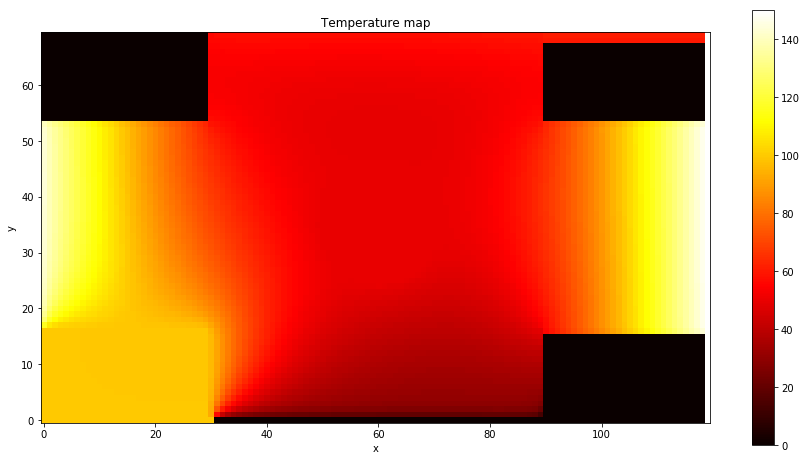

In [214]:
fig, ax = plt.subplots(figsize=(15, 8))
heatmap2d(T_prev)

ticks = ax.get_xticks()
ax.set_xticklabels([str(int(X_min + x * (X_max - X_min) // (NUMBER_X)))
                    for x in ticks])

ticks = ax.get_yticks()
ax.set_yticklabels([str(int(Y_min + x * (Y_max - Y_min) // (NUMBER_Y)))
                    for x in ticks])
